<a href="https://colab.research.google.com/github/ti-molodykh/colab/blob/main/%D0%9A%D0%B5%D0%B9%D1%81_30_01_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кейс: удержание клиентов магазина

К вам приходит руководитель продукта “Интернет-магазин Ascent” и спрашивает про удержание клиентов. У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи

Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлых годах? 

Данные:

* есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
* orders.csv, customers.csv  


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Загрузка данных:

In [ ]:
customers = pd.read_csv('https://raw.githubusercontent.com/daeronel-data/data/main/customers.csv')
customers.head(3)

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale


In [ ]:
orders = pd.read_csv('https://raw.githubusercontent.com/daeronel-data/data/main/orders.csv')
orders.head(3)

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056


Сперва посмотрим на клиентские данные: можно также делить клиентов на когорты по сегментам.

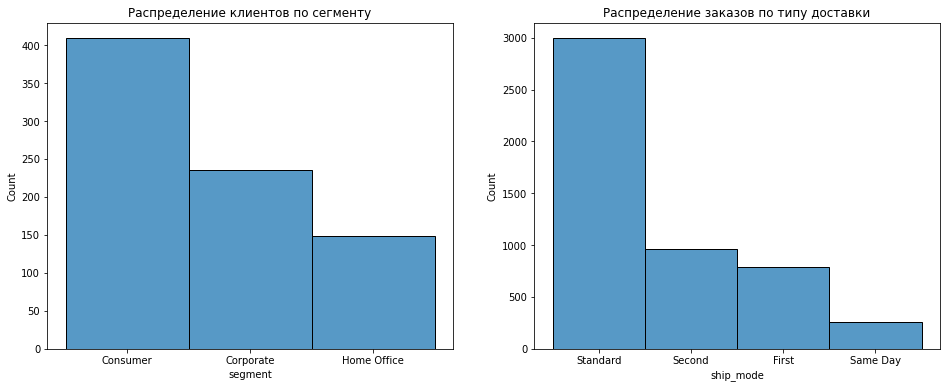

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(customers, x = 'segment', ax=ax1)
ax1.set_title('Распределение клиентов по сегменту')

sns.histplot(orders, x = 'ship_mode', ax=ax2)
ax2.set_title('Распределение заказов по типу доставки')

plt.show()

Теперь посмотрим на данные по заказам:

На график нанесем скользящее среднее за 7 дней: для каждого дня считается среднее значение за предыдущие 7 дней)

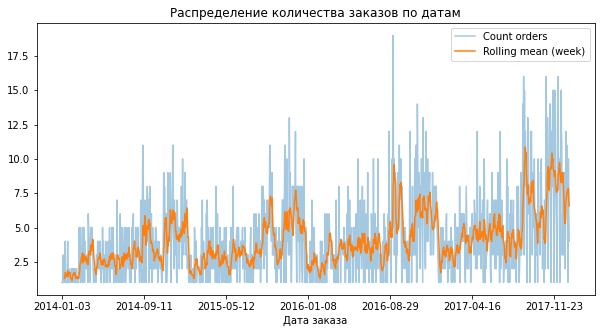

In [ ]:
plt.figure(figsize = (10,5))
dates = orders.groupby('order_date').count()['customer_id']
dates.plot(alpha = 0.4, label = 'Count orders')
dates.rolling(7).mean().plot(label = 'Rolling mean (week)') # код для расчета скользящего среднего, параметр в скобках - количество дней, по которым усредняем
plt.title('Распределение количества заказов по датам') 
plt.xlabel('Дата заказа')
plt.legend()
plt.show()

* В данных явно видна сезонность по годам и месяцам

Статистики для суммы заказов

В качестве параметра можно передать список нужных перцентилей:  
Например `percentiles=[.01, 0.99]`

In [ ]:
orders.sales.describe(percentiles=[.01, 0.99]).to_frame().T

,count,mean,std,min,1%,50%,99%,max
sales,5009.0,458.614666,954.730953,0.556,2.89688,151.96,4209.01448,23661.228


### Исследование данных по клиентам

Необходимо разделить пользователей на когорты. 
* Временем прихода клиента будем считать дату первого заказа. 
* Ушедшим клиентом будем считать такого, который сделал последний заказ год или больше назад.

Для каждого клиента посчитаем даты первого и последнего заказа, а также средний чек и количество заказов.

**Агрегация по нескольким столбцам и функциям**. 

В pandas можно делать агрегации сразу по нескольким столбцам и функциям. Для этого используется следующий синтаксис:

`df.groupby([список столбцов, по которым группируем]).agg(словарь с нужными агрегациями)`

Словарь с аггрегациями выглядит так:
```
{'столбец1 (для которого хотим рассчитать значение' : [список агрегирующих функций], 
...,  
'столбецN (для которой хотим рассчитать значение' : [список агрегирующих функций]}
```



In [ ]:
agg_dict = {
    'order_date' : ['min', 'max'],
    'sales' : ['mean', 'count']
}

In [ ]:
info = orders.groupby('customer_id').agg(agg_dict)
info.head()

order_date                    sales      
                    min         max         mean count
customer_id                                           
AA-10315     2014-03-31  2017-06-29  1112.712000     5
AA-10375     2014-04-21  2017-12-11   117.376667     9
AA-10480     2014-05-04  2017-04-15   447.628000     4
AA-10645     2014-06-22  2017-11-05   847.822500     6
AB-10015     2014-02-18  2016-11-10   295.385333     3

In [ ]:
orders.groupby('customer_id').agg({'sales' : ['mean', 'count', 'max', 'min'], 'order_date': ['min']})

sales                          order_date
                    mean count       max     min         min
customer_id                                                 
AA-10315     1112.712000     5  4406.072  26.960  2014-03-31
AA-10375      117.376667     9   513.520   5.248  2014-04-21
AA-10480      447.628000     4  1157.980  15.552  2014-05-04
AA-10645      847.822500     6  1971.460  12.960  2014-06-22
AB-10015      295.385333     3   563.940  12.624  2014-02-18
...                  ...   ...       ...     ...         ...
XP-21865      215.878000    11   708.616   9.090  2014-01-20
YC-21895     1090.870000     5  3116.490  15.700  2014-11-17
YS-21880      840.055500     8  3859.488   9.552  2015-01-12
ZC-21910      617.362077    13  1716.160   4.572  2014-10-13
ZD-21925      298.788800     5   839.944  16.720  2014-08-27

[793 rows x 5 columns]

In [ ]:
orders.groupby('customer_id').min()[['order_date']]

,order_date
customer_id,
AA-10315,2014-03-31
AA-10375,2014-04-21
AA-10480,2014-05-04
AA-10645,2014-06-22
AB-10015,2014-02-18
...,...
XP-21865,2014-01-20
YC-21895,2014-11-17
YS-21880,2015-01-12


In [ ]:
info.columns

MultiIndex([('order_date',   'min'),
            ('order_date',   'max'),
            (     'sales',  'mean'),
            (     'sales', 'count')],
           )

In [ ]:
info.columns = ['min_order_date', 'max_order_date', 'mean_sales', 'count_sales']

**Переименование столбцов по отдельности**

In [ ]:
# info = info.rename(columns={'min_order_date': 'min_date'}) 

**Объединение датафреймов**

Для объединения датафреймов используется метод merge. Он имеет такой синтаксис: 

```
левая_таблица.merge(правая_таблица,  
                  left_on = столбец по которому соединяем из левой таблицы,  
                  right_on = столбец по которому соединяем из правой таблицы,               
                  how = тип соединения)

```

Подробнее о параметрах можно почитать [в документации](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).


Для большего понимания: код в следующей ячейке аналогичен SQL выражению:  

`customer c LEFT JOIN info i ON c.id = i.customer_id `





In [ ]:
customers_info = customers.merge(info, left_on = 'id', right_on = 'customer_id', how = 'left')

Для работы с датами удобно перевести столбец в формат datetime ([статья](https://towardsdatascience.com/working-with-datetime-in-pandas-dataframe-663f7af6c587) на английском для желающих погрузиться глубже.

In [ ]:
customers_info['cohort_month'] = pd.to_datetime(customers_info['min_order_date'], infer_datetime_format=True).dt.strftime('%Y-%m') 

In [ ]:
customers_info['cohort_year'] = pd.to_datetime(customers_info['min_order_date'], infer_datetime_format=True).dt.year 

In [ ]:
customers_info.head()

,id,name,segment,state,city,min_order_date,max_order_date,mean_sales,count_sales,cohort_month,cohort_year
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson,2015-10-15,2017-01-26,382.926667,3,2015-10,2015
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles,2016-06-12,2017-12-11,223.896600,5,2016-06,2016
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale,2015-10-11,2017-12-01,433.762583,6,2015-10,2015
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles,2014-06-09,2017-12-07,781.918875,8,2014-06,2014
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord,2014-05-04,2017-04-15,447.628000,4,2014-05,2014


Посмотрим, когда к нам приходили клиенты (распределение по когортам):

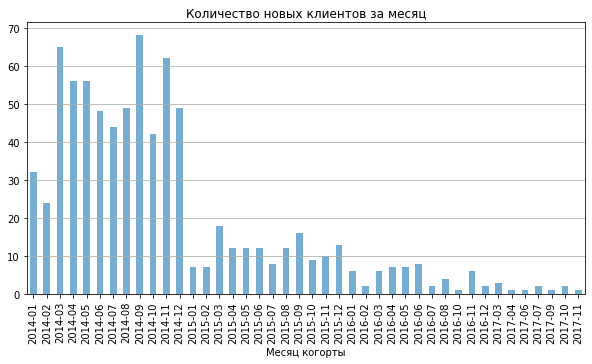

In [ ]:
customers_info.groupby('cohort_month').count()['mean_sales'].plot.bar(alpha = 0.6, figsize = (10, 5))
plt.title('Количество новых клиентов за месяц')
plt.grid(axis='y')
plt.xlabel('Месяц когорты')
plt.show()

**Подписи к столбцам на графике**

Пример кода ниже. Что важно помнить:

`rects = ax.patches` - тут хранятся координаты  
`labels = df_year.values` - список со значениями, которыми будем подписывать, из нашего датафрейма

Подписывать будем с помощью метода ax.text, разберем подробнее его параметры:

`ax.text(`
  `rect.get_x() + rect.get_width()` / 2, - координата середины столбца.  
  `height + 3`, - высота столбца + отступ (чтобы текст не сливался со столбцом), отступ можно менять.    
  `label`, - подпись.  
  `ha="center"`, - выравнивание текста по вертикали по центру.    
  `va="bottom"` - выравнивание текста по вертикали к низу)



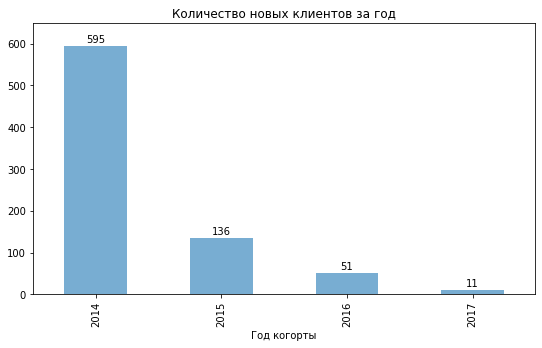

In [ ]:
df_year = customers_info.groupby('cohort_year').count()['mean_sales']

ax = df_year.plot(kind='bar', alpha = 0.6, figsize = (9, 5))


rects = ax.patches
labels = df_year.values


for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom"
    )

ax.set_title('Количество новых клиентов за год')
ax.set_xlabel('Год когорты')
ax.set_ylim(top=650)
plt.show()

In [ ]:
df_year.values

array([595, 136,  51,  11])

На данный момент еще не выяснили, как дела с оттоком, но с притоком новых клиентов точно что-то не так.  
**Приток новых клиентов падает с каждым годом.**



## Retention

In [ ]:
orders_info = orders.merge(customers_info, left_on = 'customer_id', right_on = 'id', how = 'left')
orders_info['order_date'] = pd.to_datetime(orders_info['order_date'])
orders_info['order_year'] = orders_info.order_date.dt.year
orders_info['order_month'] = orders_info.order_date.dt.strftime('%Y-%m')

In [ ]:
orders_info.head()

,id_x,order_date,ship_mode,customer_id,sales,id_y,name,segment,state,city,min_order_date,max_order_date,mean_sales,count_sales,cohort_month,cohort_year,order_year,order_month
0,100006,2014-09-07,Standard,DK-13375,377.970,DK-13375,Dennis Kane,Consumer,Ohio,Marion,2014-09-07,2017-12-11,414.810750,8,2014-09,2014,2014,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,EB-13705,Ed Braxton,Corporate,Ohio,Akron,2014-07-08,2017-11-12,404.997556,9,2014-07,2014,2014,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford,2014-03-14,2016-07-23,94.290500,4,2014-03,2014,2014,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,JC-15340,Jasper Cacioppo,Consumer,California,Los Angeles,2014-01-28,2017-09-07,17.815750,4,2014-01,2014,2014,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,JM-15655,Jim Mitchum,Corporate,New Jersey,Bridgeton,2014-04-08,2017-12-22,172.989400,5,2014-04,2014,2014,2014-04


In [ ]:
orders_info.groupby(['cohort_year', 'order_year']).agg({'customer_id': 'nunique'})

customer_id
cohort_year order_year             
2014        2014                595
            2015                437
            2016                485
            2017                517
2015        2015                136
            2016                102
            2017                120
2016        2016                 51
            2017                 45
2017        2017                 11

In [ ]:
def cohort_column(df):
    df['cohort_period'] = np.arange(len(df))
    return df

In [ ]:
df = orders_info.groupby(['cohort_year', 'order_year']).agg({'customer_id': 'nunique'}).groupby(level=0).apply(cohort_column)

In [ ]:
df.index

MultiIndex([(2014, 2014),
            (2014, 2015),
            (2014, 2016),
            (2014, 2017),
            (2015, 2015),
            (2015, 2016),
            (2015, 2017),
            (2016, 2016),
            (2016, 2017),
            (2017, 2017)],
           names=['cohort_year', 'order_year'])

Обращение по мультииндексу:




In [ ]:
df.loc[[(2014, 2014)]].customer_id.values[0]

595

**Реализация оконной функции row_number()**

Код ниже является аналогом SQL выражения

`row_number() over (partition by cohort_year order by order_year)`



In [ ]:
orders_year = (orders_info
                  .groupby(['cohort_year', 'order_year']).agg({'customer_id': 'nunique'})
                  .groupby(level=0).apply(cohort_column)
                  .rename(columns = {'customer_id': 'unique_customers'})
                  .reset_index()
                  .set_index(['cohort_year', 'cohort_period']) 
              )
orders_year

order_year  unique_customers
cohort_year cohort_period                              
2014        0                    2014               595
            1                    2015               437
            2                    2016               485
            3                    2017               517
2015        0                    2015               136
            1                    2016               102
            2                    2017               120
2016        0                    2016                51
            1                    2017                45
2017        0                    2017                11

In [ ]:
cohort_group_size = orders_year['unique_customers'].groupby(level=0).first()
cohort_group_size

cohort_year
2014    595
2015    136
2016     51
2017     11
Name: unique_customers, dtype: int64

In [ ]:
orders_year['unique_customers'].unstack(0)

cohort_year,2014,2015,2016,2017
cohort_period,,,,
0,595.0,136.0,51.0,11.0
1,437.0,102.0,45.0,NaN
2,485.0,120.0,NaN,NaN
3,517.0,NaN,NaN,NaN


In [ ]:
user_retention = orders_year['unique_customers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

cohort_year,2014,2015,2016,2017
cohort_period,,,,
0,1.000000,1.000000,1.000000,1.0
1,0.734454,0.750000,0.882353,NaN
2,0.815126,0.882353,NaN,NaN
3,0.868908,NaN,NaN,NaN


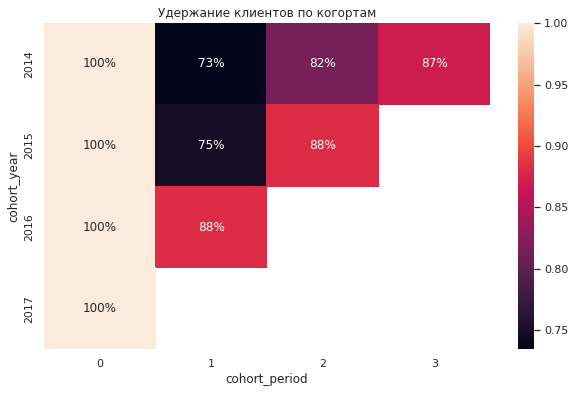

In [ ]:
sns.set(style='white')
plt.figure(figsize=(10, 6))
plt.title('Удержание клиентов по когортам')
sns.heatmap(user_retention.T, annot=True, fmt='.0%')
plt.show()

Аналогичная диаграмма с разбиением по месяцам бесполезна - в когортах 2016 и 2017 слишком мало людей. Но на основе этой диаграммы можно сделать вывод - в 2017 году не было проблем с оттоком клиентов, более того - старые клиенты стали совершать больше заказов.

**Средний чек по годам и когортам**

Посмотрим как менялся средний чек

In [ ]:
orders_sales = (orders_info
                  .groupby(['cohort_year', 'order_year']).mean()['sales']
                  .to_frame()
                  .groupby(level=0).apply(cohort_column)
                  .reset_index()
                  .set_index(['cohort_year', 'cohort_period']) 
               )

mean_sales = orders_sales['sales'].unstack(0).round(2)

In [ ]:
mean_sales

cohort_year,2014,2015,2016,2017
cohort_period,,,,
0,499.74,456.23,526.96,395.36
1,452.47,462.76,479.58,NaN
2,456.74,449.74,NaN,NaN
3,427.10,NaN,NaN,NaN


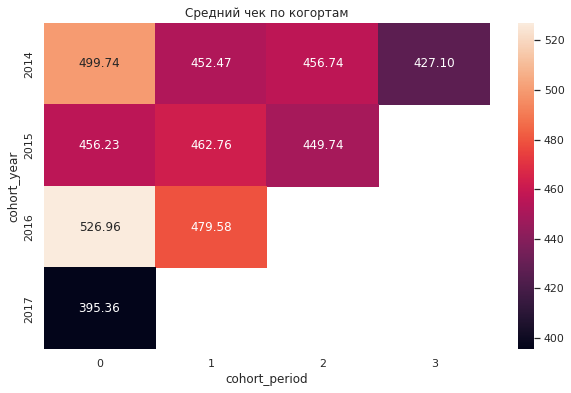

In [ ]:
sns.set(style='white')
plt.figure(figsize=(10, 6))
plt.title('Средний чек по когортам')
sns.heatmap(mean_sales.T, annot=True, fmt='.2f')
plt.show()

В 2017 году средний чек уменьшился у всех когорт пользователей!

## Выводы: 

* **Отток клиентов не наблюдается** - наоборот, старые клиенты стали делать больше заказов. 

Следовательно, проблемы с доставкой не оказали существенного влияния на эти показатели.  

Однако, в ходе исследования обнаружились другие проблемы: 
* **Приток новых клиентов значительно падает** каждый год.
* В данном году **средний чек снизился** по всем клиентам по сравнению с прошлыми годами.

Скорее всего они не были вызваны проблемами с доставкой, необходимо искать причины в другом.